
# TensorFlow Object Detection: Подготовка данных для обучения

https://github.com/tensorflow/models/tree/master/research/object_detection

### Рабочая директория
Все данные будем хранить в директории `/content/drive/My Drive/tf_od_demo` (TensorFlow Object Detection Demo)

При первом запуске создадим директорию (если её еще не существует), в противном случае надо заменить True на False.

При последующих подключениях к диску (в том числе в других ноутбуках) директорию создавать не надо, в ней уже будут сохранены все данные, которые мы туда поместили.

In [1]:
if True:
    !mkdir "tf_tennis"
%cd "tf_tennis"

mkdir: cannot create directory ‘tf_tennis’: File exists
/home/yapor/ml/tf_tennis


In [2]:
!cd models/research && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim && echo $PYTHONPATH
!echo $PYTHONPATH

:/home/yapor/ml/tf_tennis/models/research:/home/yapor/ml/tf_tennis/models/research/slim



In [5]:
    
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import pathlib
import itertools
import random

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

from object_detection.utils import config_util
from object_detection.utils import colab_utils
#from object_detection.builders import modelx_builder
%matplotlib inline

2023-05-24 19:29:35.646988: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-24 19:29:35.768797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 19:29:36.362082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'google.colab'

### Подготовка библиотеки `object_detection`
Библиотека `object_detection` находится в репозитории `tensorflow/models` в разделе `research`

Необходимо склонировать код библиотеки и сконфигурировать модели (сбилдить прото модели).

Этот шаг нужно сделать один раз (не повторять, если папка `models` уже находится в текущей директории).

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

In [2]:
if True:
  
    !git clone https://github.com/tensorflow/models
    !cd models/research && protoc object_detection/protos/*.proto --python_out=.
    !cd models/research && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim && python object_detection/builders/model_builder_test.py

fatal: destination path 'models' already exists and is not an empty directory.
2023-05-21 08:39:02.968830: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 08:39:02.989425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 08:39:03.383855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yapor/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new featur

In [2]:
!cp models/research/object_detection/packages/tf2/setup.py .
!python -m pip install .




Processing /home/yapor/ml/tf_tennis
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1203 sha256=d968a09a8ccd0aa9b7d880924b7abb6ff759124edd1f876c722e570aea314c58
  Stored in directory: /tmp/pip-ephem-wheel-cache-nd16xz5l/wheels/24/00/26/776aa63b7e54d775bd3a5d412d05de82997919252255fbda98
Successfully built object-detection
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depende

In [3]:
import sys
import os

# Assuming your directory structure is as follows:
# /path/to/your/tensorflow/models/research/
# Change the paths according to your directory structure

research_dir = 'models/research/'
slim_dir = 'models/research/slim'

sys.path.append(research_dir)
sys.path.append(slim_dir)

### Загрузка библиотек
Загрузка TensorFlow и других библиотек. Кроме того, загрузка модуля `dataset_util` из пакета `object_detection`, который будет нужен для создания датасета в нужном формате.

In [4]:
import pandas as pd
import os
from PIL import Image

import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import dataset_util

### Функция для создания одного обучающего образца
В этой функции создаётся экземпляр класса `tf.train.Example`, который соответствует одной обучающей картике. Ей могут соответствовать несколько ground-truth баундинг боксов. Однако, конкретно в данном примере на картинке есть строго один бокс. В противном случае списки `xmins`, `xmaxs`, `ymins`, `ymaxs`, `classes_text`, `classes` должны иметь соответствующее количество элементов ( = кол-ву боксов на данной картинке).

Создавать экземпляры класса `tf.train.Example` можно произвольным способом. В данном примере на вход в функцию подаётся строка из CSV файла (`annot.csv`). Главное -- заполнить соовтестсвующие поля словаре `feature={...}`

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

In [5]:
def create_tf_example(example):
  
    img_fpath = os.path.join('my_data', example.id)
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(example.id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [example.xmin / float(width)] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [example.xmax / float(width)] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [example.ymin / float(height)] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [example.ymax / float(height)] 
    # List of string class name of bounding box (1 per box)
    classes_text = [b'Cube']
    # List of integer class id of bounding box (1 per box)
    classes = [1]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

### Чтение CSV файла с разметкой
В данном файле представлена разметка обучающих изображений. Сам файл и его формат показаны лишь для примера, они никак не связаны с библиотекой `object_detection`. Наша финальная цель -- создать датасет в формате `TFRecord`, состоящий из экземпляров `tf.train.Example`.

---

В данном примере формат файла annot.csv следующий (один бокс на файл):

id,xmin,ymin,xmax,ymax

1.jpg,261,260,601,615

2.jpg,130,429,401,734

...

---

Перед запуском этого блока загрузите необходимые данные (папка `my_data`) в текущую рабочую директорию (tf_od_demo). Один из вариантов, как это можно сделать, это загрузить архив `my_data.7z`, а затем разархивировать его с помощью команды:

`!7z x my_data.7z`

In [ ]:
if True:
    !7z x my_data.7z

In [6]:
annot = pd.read_csv('my_data/annot.csv')
annot.head()

,id;xmin;ymin;xmax;ymax
0,1.jpeg;398;198;859;657
1,2.jpeg;41;49;121;129
2,3.jpeg;124;59;166;97
3,4.jpeg;328;664;377;711
4,6.jpeg;143;50;236;142


In [17]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim && python models/research/object_detection/builders/model_builder_tf2_test.py

2023-05-19 12:48:46.832404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yapor/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Running tests under Python 3.10.9: /home/yapor/anaconda3/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0519 12:48:49.303977 140383795226432 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchN

### Создание TFRecord
Здесь мы создаём финальный датасет в формате `TFRecord`, который необходим для запуска обучения TF Object Detection. 

В цикле по всем обучающим образцам создаем `TF Example` и записываем его в `TF Record`.

In [9]:
writer = tf.python_io.TFRecordWriter('my_data/train_data.record')

for idx, row in annot.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

writer.close()

AttributeError: module 'tensorflow' has no attribute 'python_io'

In [18]:
!pwd

/home/yapor/ml/tf_od_demo


In [7]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim && python models/research/object_detection/dataset_tools/create_coco_tf_record.py --logtostderr \
      --train_image_dir=IMAGES-MULT/train  \
      --test_image_dir=IMAGES-MULT/train \
      --val_image_dir=IMAGES-MULT/train \
      --train_annotations_file=IMAGES-MULT/train/result.json \
      --testdev_annotations_file=IMAGES-MULT/val/result.json \
      --val_annotations_file=IMAGES-MULT/val/result.json \
      --output_dir=data_mult_self

2023-05-24 19:40:12.245105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0524 19:40:13.472227 140450307192640 create_coco_tf_record.py:399] Found groundtruth annotations. Building annotations index.
I0524 19:40:13.472396 140450307192640 create_coco_tf_record.py:411] 0 images are missing annotations.
I0524 19:40:13.472567 140450307192640 create_coco_tf_record.py:441] On image 0 of 11
I0524 19:40:13.477218 140450307192640 create_coco_tf_record.py:465] Finished writing, skipped 0 annotations.
I0524 19:40:13.478057 140450307192640 create_coco_tf_record.py:399] Found groundtruth annotations. Building annotations index.
I0524 19:40:13.478103 140450307192640 create_coco_tf_record.py:411] 0 images are missing annotations.
I0524 19:40:13.478137 140450307192640 create_coco_tf_record.py:441] On image 0 of 2
I0524 19:40:13.479119 140450307192640 create_coco_tf_record.py:465] Finished writing, skipped 1 annotations.
I0524 19:40:13.479757 140450307

In [23]:
if True:
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
    !tar -xzf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2023-05-19 13:30:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.36.48, 2a00:1450:400e:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.36.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  14.7MB/s    in 1.3s    

2023-05-19 13:30:46 (14.7 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [25]:
!pip install wget
import wget
model_link = "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz"
wget.download(model_link)
import tarfile
tar = tarfile.open('centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz')
tar.extractall('.') 
tar.close()

Defaulting to user installation because normal site-packages is not writeable
100% [......................................................................] 237977273 / 237977273

In [7]:
!wget 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz'
!tar -xzf 'efficientdet_d1_coco17_tpu-32.tar.gz'

--2023-05-20 09:33:38--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.39.112, 2a00:1450:400e:80d::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.39.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51839363 (49M) [application/x-tar]
Saving to: ‘efficientdet_d1_coco17_tpu-32.tar.gz’

efficientdet_d1_coc 100%[===================>]  49.44M  13.5MB/s    in 3.8s    

2023-05-20 09:33:42 (13.2 MB/s) - ‘efficientdet_d1_coco17_tpu-32.tar.gz’ saved [51839363/51839363]



In [35]:
!rm -rf training-mult-self
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim && python models/research/object_detection/model_main_tf2.py\
    --pipeline_config_path=efficientdet_d1_coco17_tpu-32/pipeline-self-mult.config \
    --model_dir=training-mult-self \
    --alsologtostde

2023-05-24 20:10:08.705260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yapor/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0524 20:10:48.672087 140669803599680 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0524 20:10:48.748535 140669803599680 config_ut

In [36]:
!rm -rf save-frozen-mult-self
!export PYTHONPATH=$PYTHONPATH:models:models/research:models/research/slim ; python models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=efficientdet_d1_coco17_tpu-32/pipeline-self-mult.config \
    --trained_checkpoint_dir=training-mult-self \
    --output_directory=save-frozen-mult-self/

2023-05-24 20:18:02.269560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0524 20:18:05.274812 139652599019328 ssd_efficientnet_bifpn_feature_extractor.py:150] EfficientDet EfficientNet backbone version: efficientnet-b1
I0524 20:18:05.274919 139652599019328 ssd_efficientnet_bifpn_feature_extractor.py:152] EfficientDet BiFPN num filters: 88
I0524 20:18:05.274956 139652599019328 ssd_efficientnet_bifpn_feature_extractor.py:153] EfficientDet BiFPN num iterations: 4
I0524 20:18:05.276963 139652599019328 efficientnet_model.py:143] round_filter input=32 output=32
I0524 20:18:05.303681 139652599019328 efficientnet_model.py:143] round_filter input=32 output=32
I0524 20:18:05.303778 139652599019328 efficientnet_model.py:143] round_filter input=16 output=16
I0524 20:18:05.368745 139652599019328 efficientnet_model.py:143] round_filter input=16 output=16
I0524 20:18:05.368835 139652599019328 efficientnet_model.py:143] round_filter input=24 output=2

In [38]:
detection_model = tf.saved_model.load('save-frozen-mult-self/saved_model', tags=[tf.saved_model.SERVING])

In [37]:
PATH_TO_LABELS = 'data/valid/hb_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'brain'}, 2: {'id': 2, 'name': 'heart'}}


In [11]:
PATH_TO_LABELS = 'data/test/tennis-balls_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'TENNIS BALL'}}


In [15]:
import numpy.core.multiarray
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import config_util
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

/home/yapor/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [52]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
    
  print(output_dict['num_detections'])

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.01,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [17]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.

  boxes, classes, scores = output_dict['detection_boxes'], output_dict['detection_classes'], output_dict['detection_scores']

  indices = np.where(scores > 0.9)

  filtered_boxes = boxes[indices]
  filtered_classes = classes[indices]
  filtered_scores = scores[indices]

  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      filtered_boxes,
      filtered_classes,
      filtered_scores,
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

100


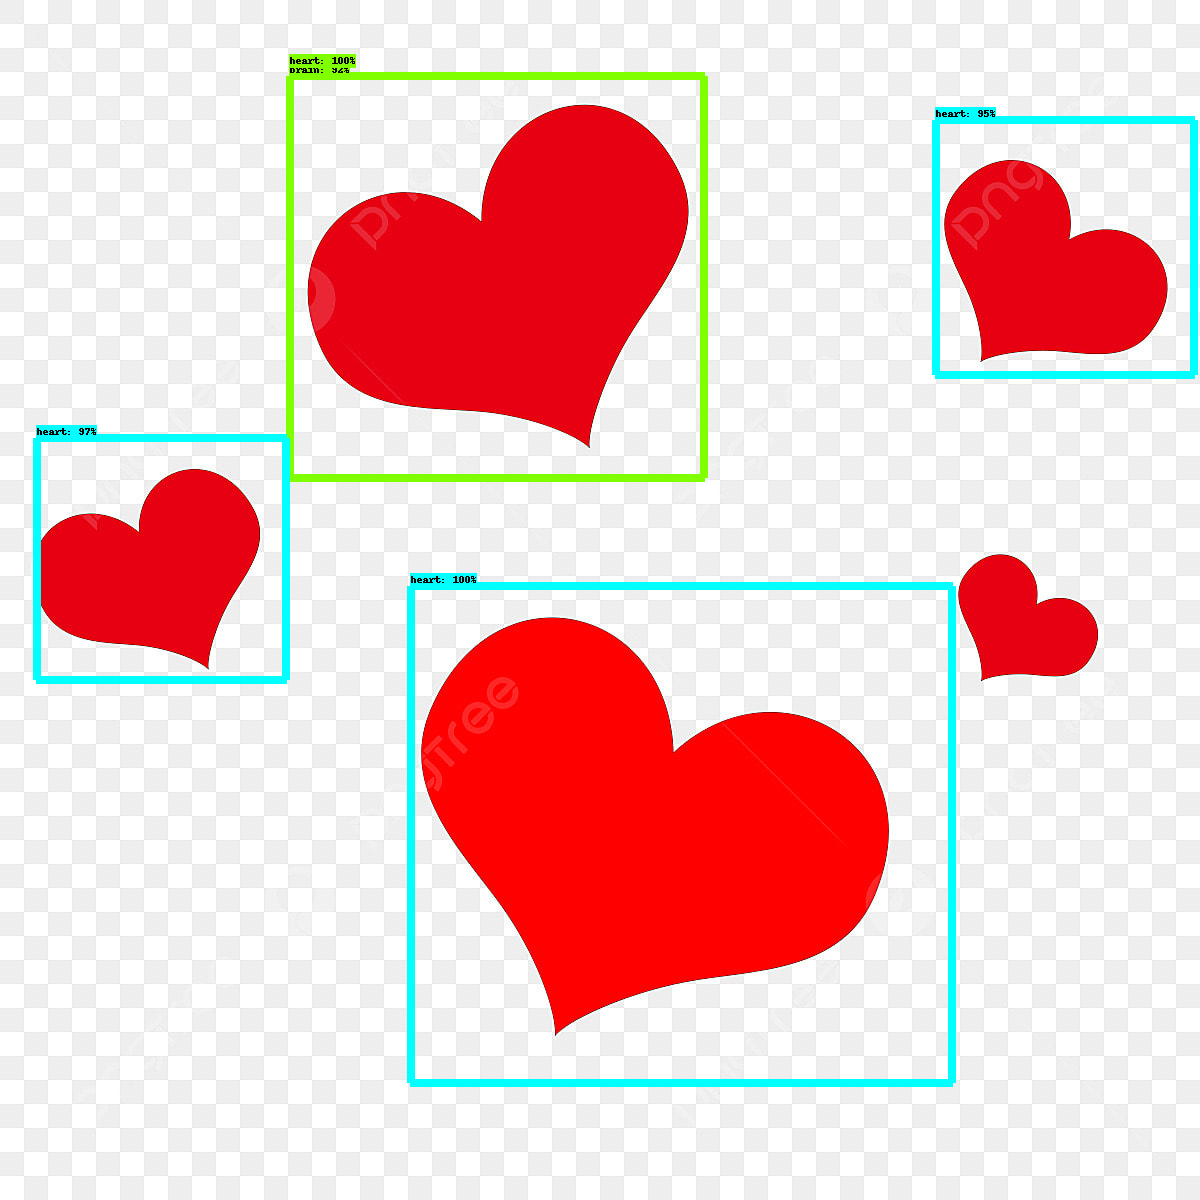

In [53]:
show_inference(detection_model, '9.jpg')